# Morphology And Blob Analysis

In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

#Morphology
def add_salt_and_pepper(image, prob=0.04):
    s_n_p = np.random.rand(image.shape[0], image.shape[1])
    p = s_n_p > 1 - 0.5*prob
    s = s_n_p < 0.5*prob

    noisy = image
    noisy[np.nonzero(p)] = 0
    noisy[np.nonzero(s)] = 255

    return noisy

In [3]:
#Read image and add noise
img = cv2.imread(r'skin_map.jpg', 0)
img[img >= 128] = 255
img[img < 128] = 0
img_noisy = add_salt_and_pepper(np.copy(img), prob=0.004)

## Morphology

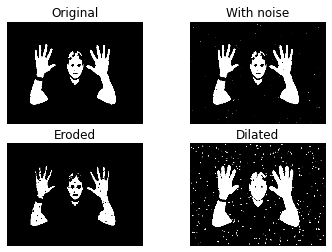

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel = kernel & np.transpose(kernel)
#erode
img_eroded = cv2.erode(img_noisy, kernel)

#dilate
img_dilated = cv2.dilate(img_noisy, kernel)


plt.figure(1)
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(img_noisy, cmap='gray')
plt.title('With noise'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(img_eroded, cmap='gray')
plt.title('Eroded'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_dilated, cmap='gray')
plt.title('Dilated'), plt.xticks([]), plt.yticks([])
plt.show()

Erosion - removes noise. Dilation - removes holes and joins nearby blobs

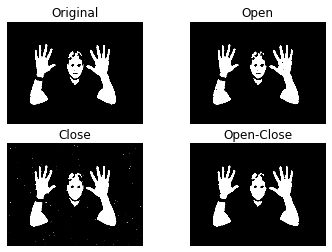

In [6]:
#open - denoise (first erode then dilate)
img_open = cv2.dilate(img_eroded, kernel)

#close - hole filler (dilate then erode)
img_close = cv2.erode(img_dilated, kernel)

#open then close
img_open_close = cv2.dilate(img_open, kernel)
img_open_close = cv2.erode(img_open_close, kernel)

plt.figure(2)
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(img_open, cmap='gray')
plt.title('Open'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(img_close, cmap='gray')
plt.title('Close'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_open_close, cmap='gray')
plt.title('Open-Close'), plt.xticks([]), plt.yticks([])
plt.show()

##     Blob Analysis          

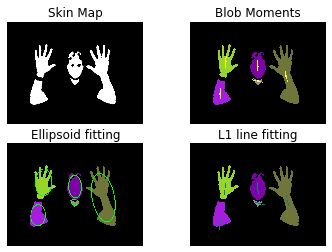

The End


In [7]:
contours, hierarchy = cv2.findContours(np.copy(img_open_close), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


def make_labeled_image(img_gray, contours):
    #np.random.seed(2222)

    labeled_img = np.zeros(img_gray.shape + (3, ), np.uint8)
    pnts_list = []
    for cnt in contours:
        color = (255. * np.random.rand(3, )).astype('uint8')

        mask = np.zeros(img_open_close.shape, np.uint8)
        cv2.drawContours(mask, [cnt], 0, 255, -1, 8)
        pixel_points = cv2.findNonZero(mask)#(x,y)

        labeled_img[mask == 255] = color
        pnts_list.append(pixel_points)#Who knows? You might need this

    return labeled_img, pnts_list

labeled_img1, pnts_list = make_labeled_image(img_open_close, contours)
labeled_img2 = np.copy(labeled_img1)
labeled_img3 = np.copy(labeled_img1)

k = 0
for cnt in contours:

    pixel_points = pnts_list[k]

    M = cv2.moments(cnt)#expects to get a contour - uses greens theorem

    #center of blob
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    #orientation of blob from moments
    #central moments
    nu20_tag = M['nu20']/M['m00']
    nu02_tag = M['nu02']/M['m00']
    nu11_tag = M['nu11']/M['m00']
    theta = 0.5*math.atan2(2*nu11_tag, nu20_tag - nu02_tag)

    pt1 = np.array((cx, cy)) + 20*np.array((np.cos(theta), np.sin(theta)))
    pt2 = np.array((cx, cy)) - 20*np.array((np.cos(theta), np.sin(theta)))

    cv2.rectangle(labeled_img1, (cx-3, cy-3), (cx+3, cy+3), (255, 255, 255), 1, 8)
    cv2.line(labeled_img1, tuple(pt1.astype('int32')), tuple(pt2.astype('int32')), (255, 255, 0), thickness=2,
             lineType=8)

    #ellipsoid outline of blob
    ellipse = cv2.fitEllipse(pixel_points)
    im = cv2.ellipse(labeled_img2, ellipse, (0, 255, 0), 2)

    (x, y), (MA, ma), angle = cv2.fitEllipse(pixel_points)#yet another way to get the angle


    #line fit - total least squares
    rows, cols = img.shape[:2]
    #DIST_L1 = 1: distance = |x1-x2| + |y1-y2| */, DIST_L2 = 2: the simple euclidean distance, DIST_C = : distance = max(|x1-x2|,|y1-y2|) */, CV_DIST_L12     =4,

    [vx, vy, x, y] = cv2.fitLine(pixel_points, 1, 0, 0.01, 0.01)
    pt1 = (np.array((x, y)) + 20*np.array((vx, vy))).astype('int32')
    pt2 = (np.array((x, y)) - 20*np.array((vx, vy))).astype('int32')

    cv2.line(labeled_img3, tuple(pt1), tuple(pt2), (0, 128, 128), 2, 8)
    k += 1


plt.figure(3)
plt.subplot(2, 2, 1), plt.imshow(img_open_close, cmap='gray')
plt.title('Skin Map'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(labeled_img1, interpolation='nearest')
plt.title('Blob Moments'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(labeled_img2, interpolation='nearest')
plt.title('Ellipsoid fitting'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(labeled_img3, interpolation='nearest')
plt.title('L1 line fitting'), plt.xticks([]), plt.yticks([])
plt.show()
print "The End"